## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import zipfile
import cdsapi
import zipfile
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt

from scripts.config_NOR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [3]:
!pip show cdsapi

Name: cdsapi
Version: 0.7.5
Summary: Climate Data Store API
Home-page: https://github.com/ecmwf/cdsapi
Author: ECMWF
Author-email: software.support@ecmwf.int
License: Apache 2.0
Location: /home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages
Requires: datapi, requests, tqdm
Required-by: massbalancemachine


In [ ]:
RUN = True
if RUN:
    dataset = "reanalysis-era5-land-monthly-means"
    request = {
        "product_type": ["monthly_averaged_reanalysis"],
        "variable": ['10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation'],
        "year": [
            "1950", "1951", "1952",
            "1953", "1954", "1955",
            "1956", "1957", "1958",
            "1959", "1960", "1961",
            "1962", "1963", "1964",
            "1965", "1966", "1967",
            "1968", "1969", "1970",
            "1971", "1972", "1973",
            "1974", "1975", "1976",
            "1977", "1978", "1979",
            "1980", "1981", "1982",
            "1983", "1984", "1985",
            "1986", "1987", "1988",
            "1989", "1990", "1991",
            "1992", "1993", "1994",
            "1995", "1996", "1997",
            "1998", "1999", "2000",
            "2001", "2002", "2003",
            "2004", "2005", "2006",
            "2007", "2008", "2009",
            "2010", "2011", "2012",
            "2013", "2014", "2015",
            "2016", "2017", "2018",
            "2019", "2020", "2021",
            "2022", "2023", "2024"
        ],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "time": ["00:00"],
        "data_format": "netcdf",
        "download_format": "zip",
        'area': [
                72,    # North latitude
                4,     # West longitude
                57,    # South latitude
                32,    # East longitude
            ]
    }

    client = cdsapi.Client()
    client.retrieve(dataset, request).download(path_ERA5_raw +'download.netcdf.zip')

with zipfile.ZipFile(path_ERA5_raw +'download.netcdf.zip', 'r') as zip_ref:
    zip_ref.extractall(path_ERA5_raw)

2025-05-07 09:57:57,160 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-07 09:57:57,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-07 09:57:58,217 INFO Request ID is 13fea3a7-bee4-401a-8081-2dcbba5d347f
2025-05-07 09:57:58,274 INFO status has been updated to accepted
2025-05-07 09:58:48,894 INFO status has been updated to running
2025-05-07 11:04:29,407 INFO status has been updated to successful


6a043635e0a92f8f9a602d7de5dc6534.zip:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

In [34]:
dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": ["geopotential"],
    "year": ["2024"],
    "month": ["06"],
    "day": ["01"],
    "time": ["12:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(path_ERA5_raw+'era5_geopotential_pressure_wholeworld.nc')

2025-05-07 13:35:02,857 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-07 13:35:02,859 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-07 13:35:03,472 INFO Request ID is 7c543bff-34b7-4d91-acce-abb37ec71d2e
2025-05-07 13:35:03,529 INFO status has been updated to accepted
2025-05-07 13:35:17,118 INFO status has been updated to running
2025-05-07 13:35:24,779 INFO status has been updated to successful


47e98a854fe750f6e1212acdec907457.nc:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

'/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw/era5_geopotential_pressure_wholeworld.nc'

## Download monthly ERA5-Land variables:

In [ ]:
"""
RUN = True
if RUN:
    os.makedirs(path_ERA5_raw, exist_ok=True)
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            'product_type': ['monthly_averaged_reanalysis'],
            'variable': [
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation',
            ],
            'year': [
                '2011',
                '2012',
                '2013',
                '2014',
                '2015',
                '2016',
                '2017',
                '2018',
                '2019',
                '2020',
                '2021',
                '2022',
                '2023',
                '2024',
            ],
            'month': [
                '01',
                '02',
                '03',
                '04',
                '05',
                '06',
                '07',
                '08',
                '09',
                '10',
                '11',
                '12',
            ],
            'time': ['00:00'],
            "data_format": "netcdf",
            "download_format": "zip",
            'area': [
                72,    # North latitude
                30,     # West longitude 
                70,    # South latitude
                32,    # East longitude
            ]
        }, path_ERA5_raw+'download.netcdf.zip')
    with zipfile.ZipFile(path_ERA5_raw+'download.netcdf.zip', 'r') as zip:
        zip.extractall(path_ERA5_raw)
    c.retrieve("reanalysis-era5-single-levels", {
            "product_type": ["reanalysis"],
            "variable": ["geopotential"],
            "year": ["2024"],
            "month": ["06"],
            "day": ["01"],
            "time": ["12:00"],
            "data_format": "netcdf",
            'area': [
                72,    # North latitude
                30,     # West longitude
                70,    # South latitude
                32,    # East longitude
            ]
        }, path_ERA5_raw+'era5_geopotential_pressure.nc')

"""

In [46]:
! ls '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw'

if os.path.exists(path_ERA5_raw + "era5_monthly_averaged_data.nc"):
    print(f"Removing old file: {path_ERA5_raw + 'era5_monthly_averaged_data.nc'}")
    os.remove(path_ERA5_raw + "era5_monthly_averaged_data.nc")
else:
    print("No previous file found to delete.")

! ls '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw'

data_stream-moda.nc	      era5_geopotential_pressure.nc
download.netcdf.zip	      era5_geopotential_pressure_wholeworld.nc
era5_geopotential_cleaned.nc  old_code_era5_monthly_averaged_data.nc
No previous file found to delete.
data_stream-moda.nc	      era5_geopotential_pressure.nc
download.netcdf.zip	      era5_geopotential_pressure_wholeworld.nc
era5_geopotential_cleaned.nc  old_code_era5_monthly_averaged_data.nc


In [47]:
! ls '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw'

data_stream-moda.nc	      era5_geopotential_pressure.nc
download.netcdf.zip	      era5_geopotential_pressure_wholeworld.nc
era5_geopotential_cleaned.nc  old_code_era5_monthly_averaged_data.nc


In [42]:
dcs = []
dcs.append(xr.open_dataset(path_ERA5_raw + 'data_stream-moda.nc'))
dcs.append(xr.open_dataset(path_ERA5_raw + 'era5_geopotential_cleaned.nc'))

In [43]:
coordsVar = []
dataVar = []
for dc in dcs:
    coordsVar += list(dc.coords)
    dataVar += list(dc.data_vars)
coordsVar = np.unique(coordsVar).tolist()
dataVar = np.unique(dataVar).tolist()
print(f"{coordsVar=}")
print(f"{dataVar=}")

coords = {k:[] for k in coordsVar}
dataTypes = {}
for dc in dcs:
    for k in dc.coords:
        if len(dc[k].shape)>0:
            coords[k] +=  list(dc[k].values)
    for k in dc.data_vars:
        if k not in dataTypes:
            dataTypes[k] = dc[k].dtype
coords = {k: np.sort(np.unique(np.array(coords[k]))) for k in coords}

coordsVar=['expver', 'latitude', 'longitude', 'number', 'valid_time']
dataVar=['fal', 'rsn', 'sd', 'sf', 'slhf', 'smlt', 'snowc', 'sshf', 'ssrd', 'str', 't2m', 'tp', 'u10', 'v10', 'z']


In [44]:
discardVar = ['expver']

size = tuple(len(coords[k]) for k in coords if len(coords[k])>0)
print(f"{size=}")
dims = tuple(k for k in coords if len(coords[k])>0 and k not in discardVar)
print(f"{dims=}")
data = {}
for k in dataVar:
    data[k] = np.zeros(size, dtype=dataTypes[k])

size=(2, 28, 28, 905)
dims=('latitude', 'longitude', 'valid_time')


In [3]:
for e, dc in enumerate(dcs):
    print(f"Processing datacube n°{e} / {len(dcs)}")
    for k in tqdm(dc.data_vars):
        idx = []
        selVar = []
        for c in dims+tuple(discardVar):
            if len(dc[c].shape)>0 and c not in discardVar:
                s = list(dc[c].values)
                sorter = np.argsort(coords[c])
                tmp = sorter[np.searchsorted(coords[c], s, sorter=sorter)]
                idx.append(tmp)
            elif c in discardVar:
                # Handle scalar values differently
                if len(dc[c].shape) == 0:  # If it's a scalar (0-dimensional)
                    s = [dc[c].values.item()]  # Convert scalar to a single-item list
                else:
                    s = list(dc[c].values)
                sorter = np.argsort(coords[c])
                tmp = sorter[np.searchsorted(coords[c], s, sorter=sorter)]
                selVar.append(tmp)
        assert len(selVar)==1
        for v in selVar[0]:
            data[k][v][idx[0],:,:][:,idx[1],:][:,:,idx[2]] = dc[k].data.transpose((1,2,0))

NameError: name 'dcs' is not defined

In [26]:
ds = xr.Dataset(
    {k: (tuple(discardVar)+dims, data[k]) for k in data},
    coords=coords
)
ds.to_netcdf(path_ERA5_raw+"old_code_era5_monthly_averaged_data.nc")

### THIS DOESNT WORK, merge doesnt interpolate and bring them both to the same grid.

In [48]:
delete_flag = True

# Delete the old file if it exists
if os.path.exists(path_ERA5_raw + "era5_monthly_averaged_data.nc") and delete_flag == True:
    print(f"Removing old file: {path_ERA5_raw + 'era5_monthly_averaged_data.nc'}")
    os.remove(path_ERA5_raw + "era5_monthly_averaged_data.nc")
else:
    print("No previous file found to delete.")

print("Loading datasets...")
monthly_ds = xr.open_dataset(path_ERA5_raw + 'data_stream-moda.nc')
geopotential_ds = xr.open_dataset(path_ERA5_raw + 'era5_geopotential_pressure.nc')

print(f"Monthly dataset: {list(monthly_ds.data_vars)}")
print(f"Geopotential dataset: {list(geopotential_ds.data_vars)}")


if 'time' in geopotential_ds.coords and 'time' in monthly_ds.coords:
    geopotential_ds = geopotential_ds.rename({'time': 'time'})

print("Merging datasets...")
merged = xr.merge([monthly_ds, geopotential_ds], compat='override')

print("Saving merged dataset...")
merged.to_netcdf(path_ERA5_raw + "era5_monthly_averaged_data.nc")

ds = xr.open_dataset(path_ERA5_raw + "era5_monthly_averaged_data.nc")
print("\nVerification:")
print(f"Variables: {list(ds.data_vars)}")
print(f"Dimensions: {dict(ds.dims)}")

# Quick check for zeros
for var in list(ds.data_vars)[:5]:
    print(f"{var}: min={float(ds[var].min().values)}, max={float(ds[var].max().values)}")

No previous file found to delete.
Loading datasets...
Monthly dataset: ['u10', 'v10', 't2m', 'fal', 'snowc', 'rsn', 'sd', 'sf', 'smlt', 'slhf', 'str', 'sshf', 'ssrd', 'tp']
Geopotential dataset: ['z']
Merging datasets...
Saving merged dataset...

Verification:
Variables: ['u10', 'v10', 't2m', 'fal', 'snowc', 'rsn', 'sd', 'sf', 'smlt', 'slhf', 'str', 'sshf', 'ssrd', 'tp', 'z']
Dimensions: {'valid_time': 905, 'latitude': 28, 'longitude': 28}
u10: min=-3.105898857116699, max=5.490514755249023
v10: min=-3.7218008041381836, max=8.122011184692383
t2m: min=254.61170959472656, max=290.4276123046875
fal: min=0.06599295139312744, max=0.8559753894805908
snowc: min=0.0, max=100.0


In [51]:
ds = xr.open_dataset(path_ERA5_raw+"era5_monthly_averaged_data.nc")

print("======== ERA5LAND DATASET STATS ========")

# Basic info
print(f"\nDimensions: {dict(ds.dims)}")
print(f"Variables: {list(ds.data_vars)}")

# Time range
if 'valid_time' in ds.coords:
    print(f"\nTime range: {ds.valid_time.values.min()} to {ds.valid_time.values.max()}")
    print(f"Number of timesteps: {len(ds.valid_time)}")

# Spatial coverage
print(f"Spatial domain: lon {ds.longitude.values.min():.2f}° to {ds.longitude.values.max():.2f}°, " 
      f"lat {ds.latitude.values.min():.2f}° to {ds.latitude.values.max():.2f}°")
print(f"Grid size: {len(ds.longitude)}×{len(ds.latitude)} points")

# Key variable stats table
print("\n--- VARIABLE STATISTICS ---")
print(f"{'Variable':<25} {'Min':>12} {'Max':>12} {'Mean':>12} {'NaNs':>8} {'Units':<10}")
print("-" * 75)

for var_name in sorted(ds.data_vars):
    var = ds[var_name]
    
    # Get stats
    min_val = float(var.min().values)
    max_val = float(var.max().values)
    mean_val = float(var.mean().values)
    nan_count = np.isnan(var).sum().values
    units = getattr(var, 'units', '')
    
    # Special handling for temperature (convert to °C)
    if var_name == '2m_temperature' and units == 'K':
        min_val -= 273.15
        max_val -= 273.15
        mean_val -= 273.15
        units = '°C'
    
    # Print stats in table format
    print(f"{var_name:<25} {min_val:>12.4f} {max_val:>12.4f} {mean_val:>12.4f} {nan_count:>8} {units:<10}")

======== ERA5LAND DATASET STATS ========

Dimensions: {'valid_time': 905, 'latitude': 28, 'longitude': 28}
Variables: ['u10', 'v10', 't2m', 'fal', 'snowc', 'rsn', 'sd', 'sf', 'smlt', 'slhf', 'str', 'sshf', 'ssrd', 'tp', 'z']

Time range: 1950-01-01T00:00:00.000000000 to 2025-04-01T00:00:00.000000000
Number of timesteps: 905
Spatial domain: lon 30.00° to 32.00°, lat 70.00° to 72.00°
Grid size: 28×28 points

--- VARIABLE STATISTICS ---
Variable                           Min          Max         Mean     NaNs Units     
---------------------------------------------------------------------------
fal                             0.0660       0.8560       0.4410   672456 (0 - 1)   
rsn                           100.0000     437.5857     204.6343   672456 kg m**-3  
sd                             -0.0000       0.4930       0.0828   672456 m of water equivalent
sf                              0.0000       0.0058       0.0009   672456 m of water equivalent
slhf                      -6713308.0000

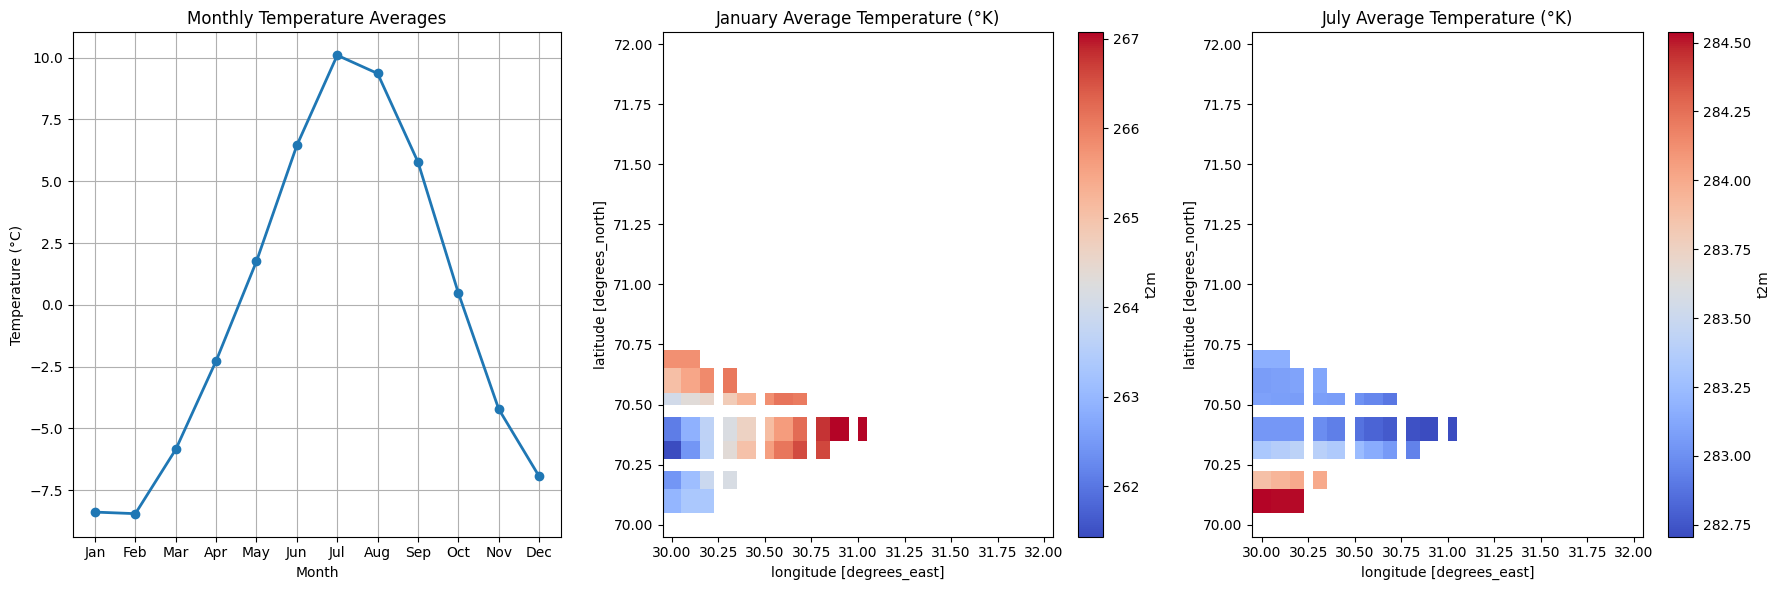


Temperature Validation:
January mean: 264.8°C
July mean: 283.2°C
Annual range: 18.5°C correct


In [50]:
# Load the dataset
ds = xr.open_dataset(path_ERA5_raw + "era5_monthly_averaged_data.nc")

# Find temperature variable
if 't2m' in ds:
    temp_var = 't2m'
elif '2m_temperature' in ds:
    temp_var = '2m_temperature'
else:
    print("Temperature variable not found")
    temp_var = None

if temp_var:
    # Create figure with three plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Monthly temperature averages
    times = pd.to_datetime(ds.valid_time.values)
    months = [t.month for t in times]
    
    # Group by month
    month_groups = {m: [] for m in range(1, 13)}
    for i, m in enumerate(months):
        month_groups[m].append(i)
    
    # Calculate monthly means
    monthly_means = []
    for m in range(1, 13):
        if month_groups[m]:
            # Get data and convert to Celsius if needed
            mean_temp = ds[temp_var].isel(valid_time=month_groups[m]).mean().values
            if hasattr(ds[temp_var], 'units') and ds[temp_var].units == 'K':
                mean_temp -= 273.15
            monthly_means.append(float(mean_temp))
        else:
            monthly_means.append(np.nan)
    
    # Plot monthly averages
    axs[0].plot(range(1, 13), monthly_means, 'o-', color='#1f77b4', linewidth=2)
    axs[0].set_title('Monthly Temperature Averages')
    axs[0].set_xlabel('Month')
    axs[0].set_ylabel('Temperature (°C)')
    axs[0].grid(True)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axs[0].set_xticks(range(1, 13))
    axs[0].set_xticklabels(month_names)
    
    # 2. January temperature map
    jan_indices = [i for i, t in enumerate(times) if t.month == 1]
    if jan_indices:
        jan_temp = ds[temp_var].isel(valid_time=jan_indices).mean(dim='valid_time')
        if hasattr(jan_temp, 'units') and jan_temp.units == 'K':
            jan_temp = jan_temp - 273.15
        jan_temp.plot(ax=axs[1], cmap='coolwarm')
        axs[1].set_title('January Average Temperature (°K)')
    
    # 3. July temperature map
    jul_indices = [i for i, t in enumerate(times) if t.month == 7]
    if jul_indices:
        jul_temp = ds[temp_var].isel(valid_time=jul_indices).mean(dim='valid_time')
        if hasattr(jul_temp, 'units') and jul_temp.units == 'K':
            jul_temp = jul_temp - 273.15
        jul_temp.plot(ax=axs[2], cmap='coolwarm')
        axs[2].set_title('July Average Temperature (°K)')
    
    plt.tight_layout()
    plt.show()
    
    # Print basic validation info
    print(f"\nTemperature Validation:")
    jan_mean = float(jan_temp.mean())
    jul_mean = float(jul_temp.mean())
    print(f"January mean: {jan_mean:.1f}°C")
    print(f"July mean: {jul_mean:.1f}°C")
    print(f"Annual range: {jul_mean - jan_mean:.1f}°C {'correct' if jul_mean > jan_mean else 'wrong'}")

In [2]:
print('-----new geopot file-----')
ds = xr.open_dataset('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw/era5_geopotential_pressure_wholeworld.nc')
display(ds)
print('-----old geopot file-----')
ds = xr.open_dataset('/home/mburlet/scratch/data/ERA5Land/raw/era5_geopotential_pressure.nc')
display(ds)

-----new geopot file-----


<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 1, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2024-06-01T12:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B ...
Data variables:
    z           (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-07T13:35 GRIB to CDM+CF via cfgrib-0.9.1...

-----old geopot file-----


<xarray.Dataset> Size: 52MB
Dimensions:    (longitude: 3600, latitude: 1801, time: 1)
Coordinates:
  * longitude  (longitude) float32 14kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 52MB ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1